## Setting

In [20]:
import os

if not os.path.exists("../small_libs"):
    print("the directory small_libs is created")
    !git clone https://github.com/vincentvigon/small_libs
    %cd small_libs
else:
    print("the directory small_libs is updated")
    !git pull https://github.com/vincentvigon/small_libs

the directory small_libs is updated
From https://github.com/vincentvigon/small_libs
 * branch            HEAD       -> FETCH_HEAD
Already up to date.


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/Othercomputers/Mon MacBook Pro/google_saved/PYTHON/small_libs
# %ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
%pwd
%ls

consecutive_windows/      grid_up/      popup_lib/
derivator/                info_helper/  poubel/
fourier_neural_operator/  paddings/     preference_sampling/


In [4]:
import small_libs.fourier_neural_operator.FNO_1d_plus as fno
#import fourier_neural_operator.test_env as te
import small_libs.grid_up.grid_up as gr
from small_libs.info_helper.info_helper import print_signature

In [5]:
pp=print
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


In [6]:
from fourier_neural_operator.test_newton.generate_data_tf import *

# Apprentissage classique

## Création des données

In [7]:
def give_me_newtonData(N):
    return NewtonData(a=0,b=1,N=N,k=lambda u: u ** 4 + 1.0,kind="gauss",BC="dirichlet")

In [8]:
data_creator_train=give_me_newtonData(200)

NewtonData with: nb points=200, kind of data:gauss


In [9]:
X,Y=data_creator_train.make_XY(batch_size=10)

traçage de la fonction generate_XY


* Les 2 channels de `X` correspondent à $f,\alpha$.
* Le channel de `Y` correspond à $U$

In [10]:
X.shape, Y.shape

(TensorShape([10, 200, 2]), TensorShape([10, 200, 1]))

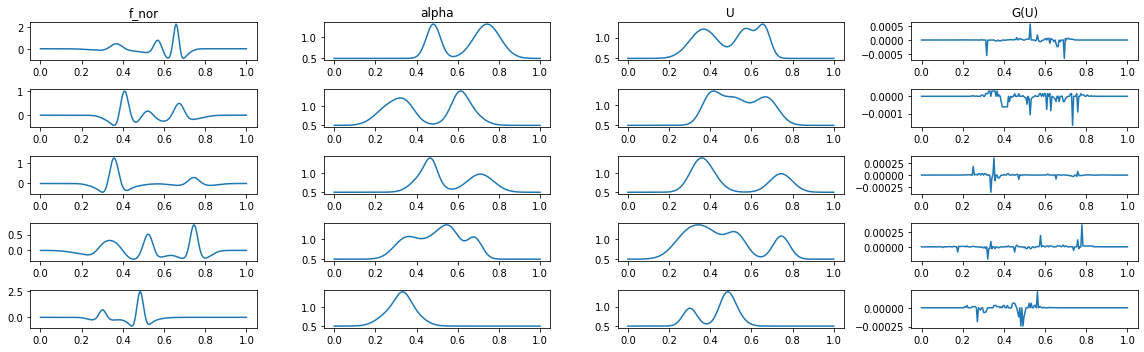

In [11]:
data_creator_train.plot_data(X,Y)

Notons qu'en 32 bit, les résidus on des pointent à 5e-4

## Définition du modèle

Voici la signature du modèle


In [13]:
print_signature(fno.FNO1d_plus.__init__)

self
modes: int
width: int
out_channels: int
nb_layer=4
first_channel_unchanged=False
freq_mix_size=0
pad_prop=0.1
pad_kind='zero_padding'
verbose=False


Quelques explications:

In [14]:
print(fno.FNO1d_plus.__init__.__doc__)


        @param modes:int, number of fourier coef keept
        @param width:int, nb_channels of hidden layers
        @param out_channels:int, dimension of output
        @param nb_layer:int,
        @param first_channel_unchanged:bool, if True, at the beginning of the training, the first channel of each hidden layer is simply the spectrum
        @param freq_mix_size:int, size of the convolutionnal kernel applyiend the frequency layers
        @param pad_prop:float, the padding is int(pad_prof*signal_size) at each border
        @param pad_kind:string, kind of padding. Eg: neumann_padding, smooth_padding,zero_padding
        @param verbose:bool, if True, more message are printed
        


Voici la signature de l'agent, qui crée le modèle et l'entraine sur step.

In [15]:
print_signature(AgentNewton.__init__)

self
order
modes
width
nb_layer
first_channel_unchanged
freq_mix_size
pad_prop
pad_kind
batch_size
only_one_optimizer
lr


In [26]:
agent= AgentNewton(
    order=2,
    modes=20,
    width=20,
    nb_layer=4,
    first_channel_unchanged=True,
    freq_mix_size=5,
    pad_prop=0,
    pad_kind="no_padding",
    batch_size=128,
    only_one_optimizer=False,
    lr=1e-3
)
data=give_me_newtonData(200)

keys=[]

NewtonData with: nb points=200, kind of data:gauss


In [27]:
for i in range(1000):
    loss=agent.train_step(data).numpy()
    losses.append(loss)
    if i%50==0:
        print(loss)

traçage de la fonction generate_XY
tf.Tensor(0.5375389, shape=(), dtype=float32)
tf.Tensor(0.031280994, shape=(), dtype=float32)
tf.Tensor(0.01036262, shape=(), dtype=float32)
tf.Tensor(0.005386491, shape=(), dtype=float32)
tf.Tensor(0.0039303266, shape=(), dtype=float32)
tf.Tensor(0.003193565, shape=(), dtype=float32)
tf.Tensor(0.0033106413, shape=(), dtype=float32)
tf.Tensor(0.0016041724, shape=(), dtype=float32)
tf.Tensor(0.0012483486, shape=(), dtype=float32)
tf.Tensor(0.00070626865, shape=(), dtype=float32)
tf.Tensor(0.0011928314, shape=(), dtype=float32)
tf.Tensor(0.0006049999, shape=(), dtype=float32)
tf.Tensor(0.0005306867, shape=(), dtype=float32)
tf.Tensor(0.003101374, shape=(), dtype=float32)
tf.Tensor(0.00077957765, shape=(), dtype=float32)
tf.Tensor(0.0004612294, shape=(), dtype=float32)
tf.Tensor(0.00037329376, shape=(), dtype=float32)
tf.Tensor(0.00033400318, shape=(), dtype=float32)
tf.Tensor(0.00063077733, shape=(), dtype=float32)
tf.Tensor(0.00044861488, shape=(), dty

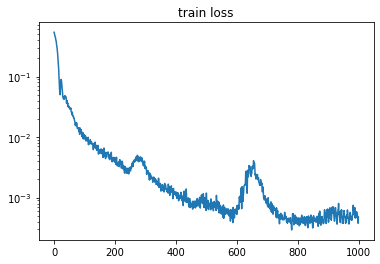

In [28]:
fig,ax=plt.subplots()
ax.plot(losses)
ax.set_title("train loss")
ax.set_yscale("log")

## Test dans la résolution de l'entrainement

In [29]:
def display_results(data_creator,model):

    nb=8
    fig,axs=plt.subplots(nb,4,sharex="all",figsize=(20,2*nb))
    X,Y=data_creator.make_XY(nb)
    Y_pred = model.call(X)
    f=X[:,:,0]*data_creator.normalisation_for_f
    alpha=X[:,:,1]

    res=data_creator.G2(X,Y)
    res_pred=data_creator.G2(X,Y_pred)
    for i in range(nb):
        axs[i,0].plot(f[i,:])
        axs[i,1].plot(alpha[i,:])
        axs[i,2].plot(Y[i,:,0],label="true")
        axs[i,2].plot(Y_pred[i,:,0],label="pred")
        axs[i,3].plot(res[i,:],label="true")
        axs[i,3].plot(res_pred[i,:],label="pred")

    axs[0,0].set_title("f")
    axs[0,1].set_title("alpha")
    axs[0,2].set_title("U")
    axs[0,3].set_title("residues")

    axs[0,2].legend()

    plt.show()


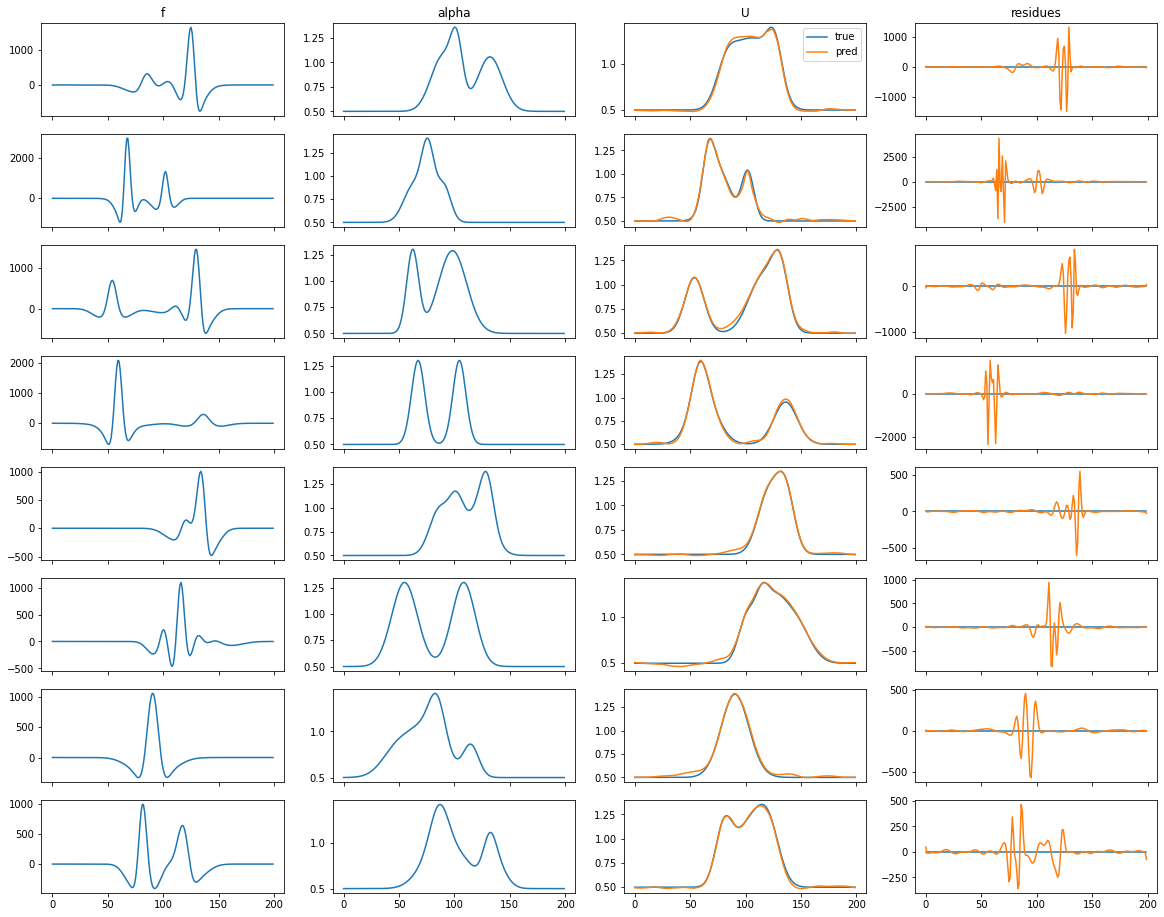

In [30]:
display_results(data_creator_train,agent.model)

## Test avec résolution supèrieure

NewtonData with: nb points=300, kind of data:gauss
traçage de la fonction generate_XY
traçage de la méthode call de FNO1d_plus, pad=30


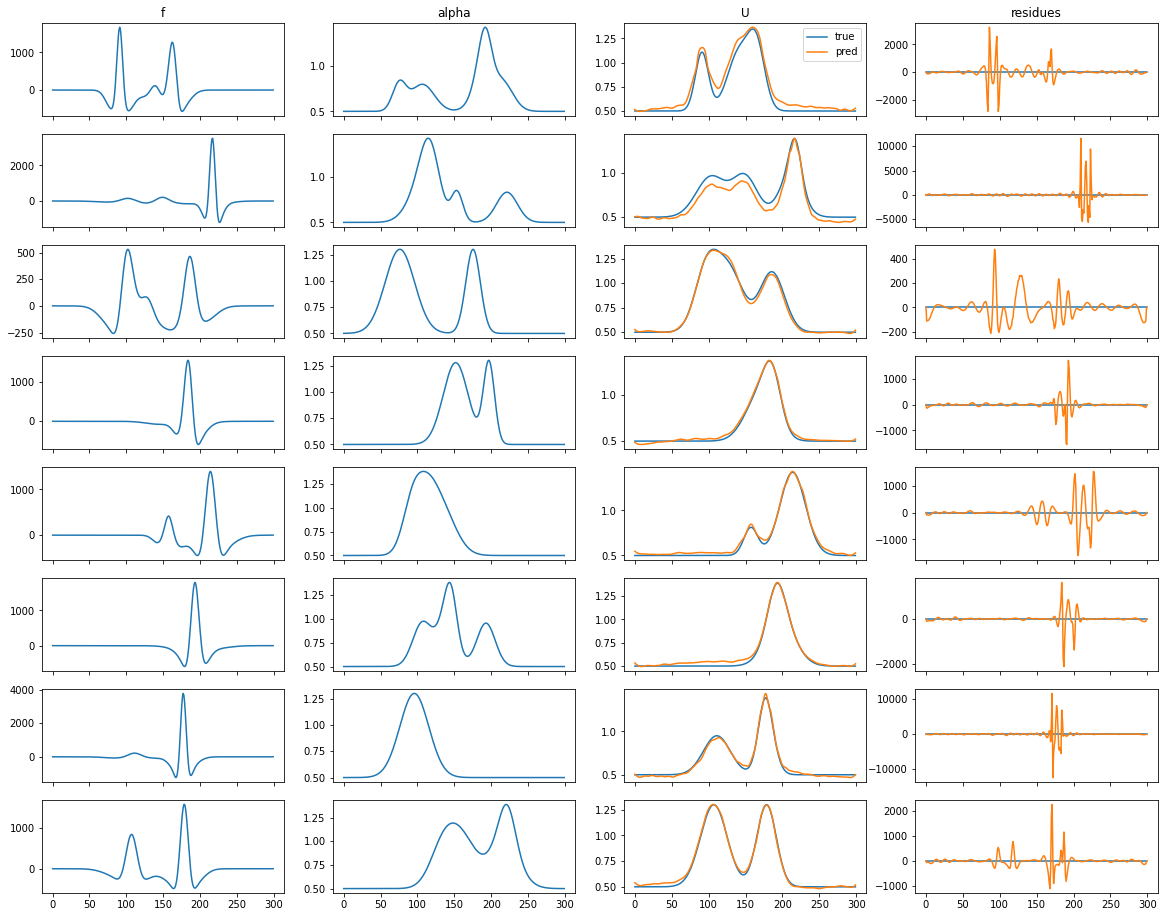

In [30]:
data_creator_test=give_me_newtonData(300)
display_results(data_creator_test,model)

## Test avec résolution inférieure

NewtonData with: nb points=100, kind of data:gauss
traçage de la fonction generate_XY
traçage de la méthode call de FNO1d_plus, pad=10


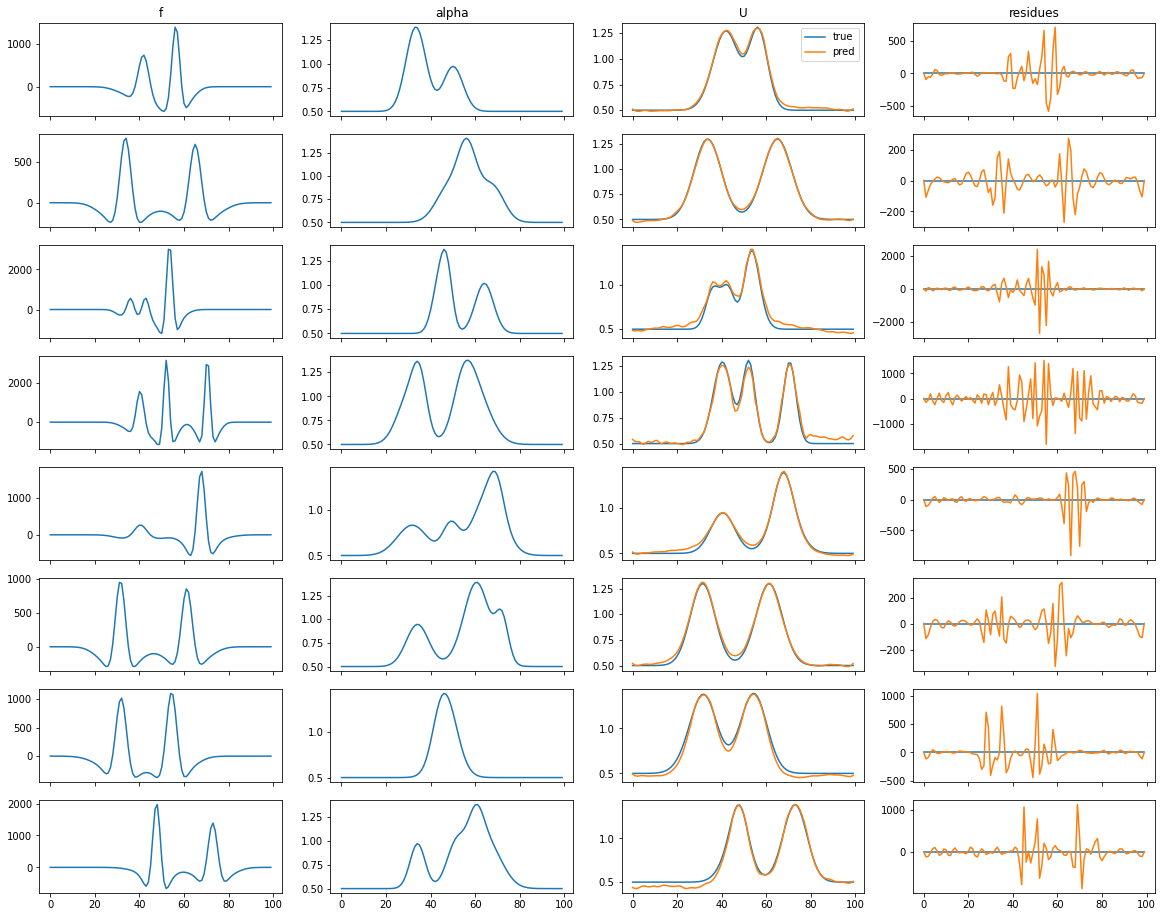

In [31]:
data_creator_test=data_creator_train=give_me_newtonData(100)
display_results(data_creator_test,model)

# Apprentissage multiple avec `grid_up`

Nous allons faire varier un à un les paramètres du FNO et tester sur différentes résolution, en utilisant `grid_up`


Sur des données périodiques, le padding est inutile. On le vérifiera en faisant varier `pad_prop`

Mais du coup on ne testera pas les différents `pad_kind` 


In [ ]:
def make_testor():
    resolutions_train=[100,150]
    resolutions_test=[50,75,100,125,150,175,200]

    creator_train={nx:give_me_newtonData(nx) for nx in resolutions_train}
    creator_test= {nx:give_me_newtonData(nx) for nx in resolutions_test}

    fixed_params = {
        "first_channel_unchanged": False,
        "pad_prop": 0.1,
        "freq_mix_size": 5,
        "pad_kind": "smooth_padding",
        "modes" : 20,
        "width" : 15,
        "nb_layer":4,
        "out_channels":1 #ne varie pas
    }

    pad_kinds=[
        'no_padding',
        #'zero_padding',
        'dirichlet_padding', 
        'neumann_padding', 
        'smooth_padding', 
        #'periodic_padding', 
        'smooth_periodizing_padding', 
        'linear_periodizing_padding']
    
    varying_params= {
        "first_channel_unchanged": [True,False],
        "pad_prop": [0,0.02,0.05,0.1,0.2],
        "freq_mix_size": [0,5,9],
        "pad_kind": pad_kinds,
        "modes" : [5,10,15,20],
        "width" : [5,10,15,20,30],
        "nb_layer":[2,3,4,5]
    }

    testor=gr.GridUp(
        fno.FNO1d_plus,
        creator_train,
        creator_test,
        fixed_params=fixed_params,
        varying_params=varying_params,
        minutes=1,
        verbose=False
    )
    return testor

testor=make_testor()

NewtonData with: nb points=100, kind of data:gauss
NewtonData with: nb points=150, kind of data:gauss
NewtonData with: nb points=50, kind of data:gauss
NewtonData with: nb points=75, kind of data:gauss
NewtonData with: nb points=100, kind of data:gauss
NewtonData with: nb points=125, kind of data:gauss
NewtonData with: nb points=150, kind of data:gauss
NewtonData with: nb points=175, kind of data:gauss
NewtonData with: nb points=200, kind of data:gauss
traçage de la fonction generate_XY


In [ ]:
testor.watch_param("first_channel_unchanged");

Look for model.first_channel_unchanged=[True, False]. Train with data-cases:[100, 150], Test with data-cases:[50, 75, 100, 125, 150, 175, 200]
Other parameters are: [('pad_prop', 0.1), ('freq_mix_size', 5), ('pad_kind', 'smooth_padding'), ('modes', 20), ('width', 15), ('nb_layer', 4), ('out_channels', 1)]
traçage de la fonction generate_XY


traçage de la fonction generate_XY
traçage de la fonction generate_XY
traçage de la fonction generate_XY
traçage de la fonction generate_XY
traçage de la fonction generate_XY
traçage de la fonction generate_XY
traçage de la fonction generate_XY
traçage de la fonction generate_XY


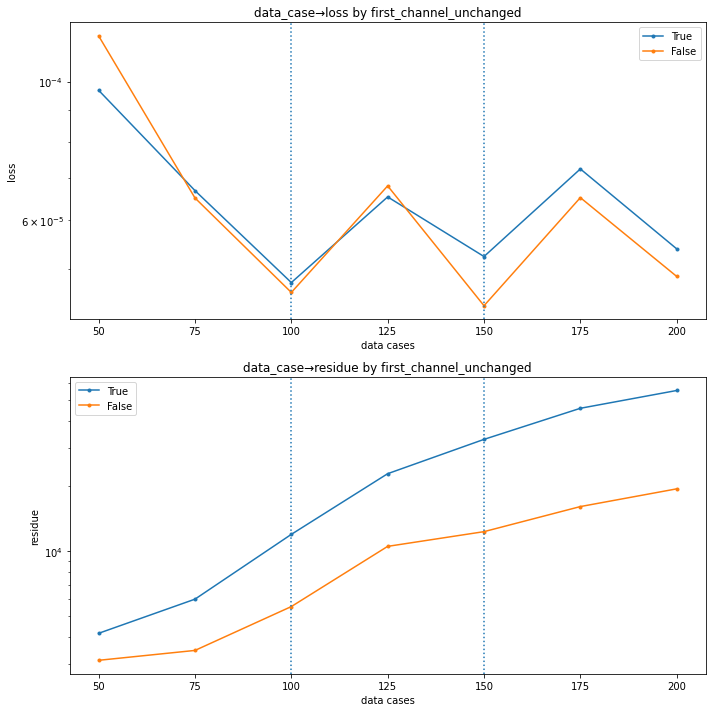

In [ ]:
testor.plot_last_result();

traçage de la fonction generate_XY
traçage de la fonction generate_XY
traçage de la fonction generate_XY
traçage de la fonction generate_XY
traçage de la fonction generate_XY
traçage de la fonction generate_XY
traçage de la fonction generate_XY


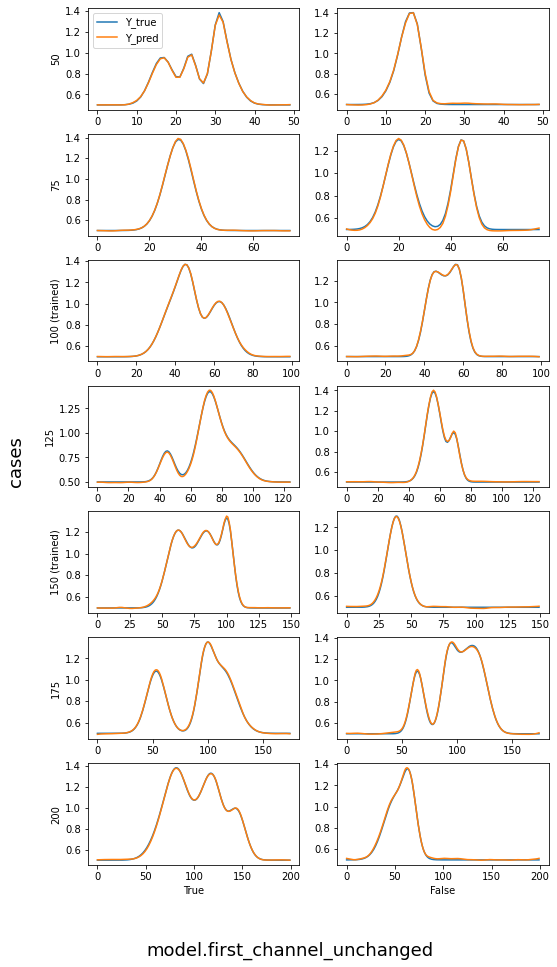

In [ ]:
testor.plot_prediction();

In [ ]:
testor.watch_param("pad_prop");

Look for model.pad_prop=[0, 0.02, 0.05, 0.1, 0.2]. Train with data-cases:[100, 150], Test with data-cases:[50, 75, 100, 125, 150, 175, 200]
Other parameters are: [('first_channel_unchanged', False), ('freq_mix_size', 5), ('pad_kind', 'smooth_padding'), ('modes', 20), ('width', 15), ('nb_layer', 4), ('out_channels', 1)]


TypeError: ignored

In [ ]:
testor.plot_last_result();

In [ ]:
testor.plot_prediction();

In [ ]:
testor.watch_param("freq_mix_size");

In [ ]:
testor.plot_last_result();

In [ ]:
testor.plot_prediction();

In [ ]:
testor.watch_param("modes");

In [ ]:
testor.plot_last_result();

In [ ]:
testor.plot_prediction();

In [ ]:
testor.watch_param("width");

In [ ]:
testor.plot_last_result();

In [ ]:
testor.plot_prediction();

In [ ]:
testor.watch_param("nb_layer");

In [ ]:
testor.plot_last_result();

In [ ]:
testor.plot_prediction();